# Country search trends

Previously, we measured Americans' expectations about how many casualties occurred during disasters in different countries. But there are many factors that might go into these judgments. Some might be general predictive properties--population, distance from the USA, etc.--but others might be more idiosyncratic--recent conflicts, actual earthquake baserates, etc. Here, we're going to try to identify some general predictors using Google trends data. To figure out good predictors, we're going to see how much countries care about each other as measured by how much they Google each other.

Our measure for how much one Country A cares about Country B is going to be the log10 ratio of how much Country A searches for Country B divided by how much Country B searches for Country B. For example, [this search](https://www.google.com/trends/explore#q=%2Fm%2F0f8l9c%2C%20%2Fm%2F09c7w0&geo=US&date=1%2F2005%20133m&cmpt=q&tz=Etc%2FGMT%2B7) is going to allow us to see how much Americans care about the French. If we look at the summary bar graph, we're going to take log10(5/79). So, rule of thumb, less negative scores indicate the country is more searched.

In [1]:
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(style="white", color_codes=True)

Let's read the raw data into a csv

In [2]:
trends_df=pd.read_csv('country_trends.csv',header=None)
trends_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,NaN,Nigeria,Japan,Pakistan,United States,France,Russia,Indonesia,Mexico,Rwanda,...,Germany,Spain,Thailand,South Africa,India,Australia,Brazil,Canada,Belgium,Netherland
1,Nigeria,68,1,0,14,2,1,0,0,0,...,2,1,0,3,2,2,1,5,1,1
2,Japan,0,66,1,16,3,2,4,3,0,...,2,2,3,2,3,4,8,2,1,1
3,Pakistan,0,1,70,4,0,1,0,0,0,...,1,0,1,0,5,2,0,2,0,0
4,United States,1,6,2,80,5,5,1,14,0,...,5,4,2,2,9,6,8,12,1,1


And now let's turn it into our country caring measure

In [3]:
self_df=pd.DataFrame({'self_num':[int(trends_df.iloc[i,i]) for i in range(1,40)],
 'searcher':[trends_df.iloc[0,i] for i in range(1,40)]})

In [4]:
searcher=[]
searchee=[]
search_num=[]
for s_er in range(1,40):
    for s_ee in range(1,40):
        if s_er!=s_ee:
            searcher.append(trends_df.iloc[s_er,0])
            searchee.append(trends_df.iloc[0,s_ee])        
            search_num.append(int(trends_df.iloc[s_er,s_ee]))
search_df=pd.DataFrame({'searcher':searcher,'searchee':searchee,'search_num':search_num})
search_df=pd.merge(search_df,self_df,how='inner',on='searcher')
search_df.loc[:,'search_score']=np.log10((search_df.loc[:,'search_num']/search_df.loc[:,'self_num'])+np.spacing(1))

Ok, first analysis--What countries were searched the most?

In [5]:
mean_searchee=search_df.loc[:,['searchee','search_score']].groupby('searchee').mean().reset_index()
mean_searchee.columns=['searchee', 'mean']
std_searchee=search_df.loc[:,['searchee','search_score']].groupby('searchee').std()
num_search=np.sqrt(search_df.loc[:,['searchee','search_score']].groupby('searchee').size())
sem_searchee=std_searchee.divide(num_search,axis=0).reset_index()
sem_searchee.columns=['searchee', 'SEM']

searchee_df=pd.merge(mean_searchee,sem_searchee,how='inner',on='searchee')
searchee_df=searchee_df.sort_values(by='mean').reset_index()

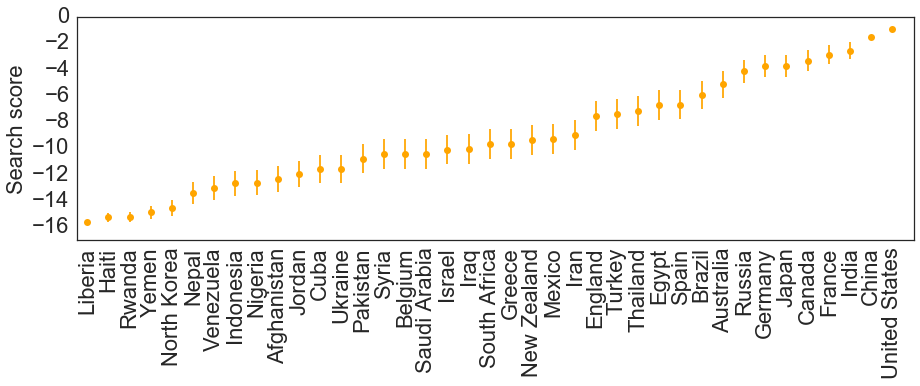

In [6]:
plt.figure(figsize=(15,4))

plt.errorbar(range(len(searchee_df)), searchee_df['mean'], yerr=searchee_df['SEM'],c='orange',fmt='o')
plt.ylabel('Search score',fontsize='22')

plt.xticks(range(len(searchee_df)), searchee_df['searchee'], rotation='90',fontsize=22)
plt.yticks(fontsize=22)
plt.axis([-.5, len(searchee_df), -17, 0])
plt.show()

Let's see how these results compare to our casualty results

In [7]:
countries=['Nigeria','Japan','Pakistan','United States','France','Russia', \
          'Indonesia','Mexico','Rwanda','Haiti','Jordan','Cuba', \
          'Liberia','North Korea','Syria','Iraq','Yemen','Ukraine', \
          'Afghanistan','Turkey','Venezuela','Egypt','Iran','Saudi Arabia', \
          'China','Israel','Greece','Nepal','England','New Zealand', \
          'Germany','Spain','Thailand','South Africa','India','Australia', \
          'Brazil','Canada','Belgium','Netherlands'] # These are mapped onto art_id in our dataset

casualty_df=pd.read_csv('../pilot_survey_v2/mturk_data_itNews_v3.csv', quotechar="'",header=None,usecols=[5,9,10,11,12,])
casualty_df.columns=['true_country','true_casualties','resp_country','resp_poster','resp_casualties']

casualty_df.loc[:,'true_casualties_log10']=np.log10(casualty_df.loc[:,'true_casualties'])
casualty_df.loc[:,'resp_casualties_log10']=np.log10(casualty_df.loc[:,'resp_casualties'])

casualty_df.loc[:,'true_name']=casualty_df.loc[:,'true_country'].apply(lambda x:countries[x])
casualty_df=casualty_df.loc[:,['true_name','resp_casualties_log10']]

In [8]:
mean_casualty=casualty_df.groupby('true_name').mean().reset_index()
std_casualty=casualty_df.groupby('true_name').std()
num_casualty=np.sqrt(casualty_df.loc[:,['true_name','resp_casualties_log10']].groupby('true_name').size())

sem_searchee=std_casualty.divide(num_casualty,axis=0).reset_index()
country_casualty=pd.merge(mean_casualty,sem_searchee,on='true_name')
country_casualty.columns=['true_name','mean_cas','SEM_cas']

searchee_df2=pd.merge(searchee_df,country_casualty,left_on='searchee',right_on='true_name')
del searchee_df2['true_name']

print searchee_df2.head()

   index     searchee       mean       SEM  mean_cas   SEM_cas
0     20      Liberia -15.653560  0.000000  1.742051  0.170930
1     12        Haiti -15.291705  0.361854  2.689742  0.175097
2     28       Rwanda -15.276144  0.377416  2.591224  0.142209
3     38        Yemen -14.905599  0.521758  2.355522  0.140432
4     25  North Korea -14.546917  0.621503  2.285098  0.127236


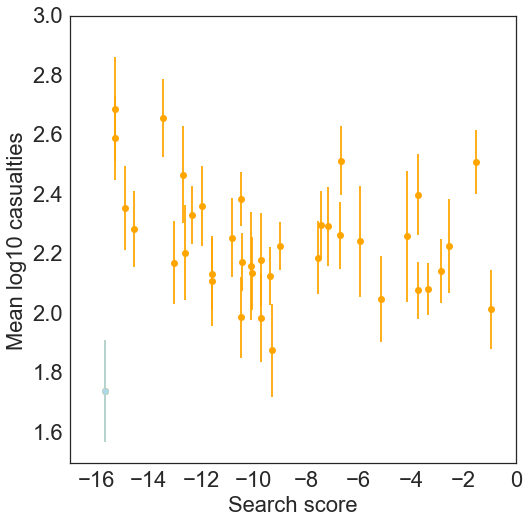

In [11]:
plt.figure(figsize=(8,8))

plt.errorbar(searchee_df2['mean'], searchee_df2['mean_cas'], yerr=searchee_df2['SEM_cas'],c='orange',fmt='o')

# liberia
liberia_df=searchee_df2[searchee_df2['searchee']=='Liberia']
plt.errorbar(liberia_df['mean'], liberia_df['mean_cas'], yerr=liberia_df['SEM_cas'],c='lightblue',fmt='o')

plt.xlabel('Search score',fontsize='22')
plt.ylabel('Mean log10 casualties',fontsize='22')
#plt.xticks(range(len(searchee_df)), searchee_df['searchee'], rotation='90',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.axis([-17, 0, 1.5, 3])
plt.show()

I made Liberia blue here (bottom-left). It's a weird case--It's rarely searched and in our casualty results people seem to assume it's a small island.

In [12]:
not_liberia_df=searchee_df2[searchee_df2['searchee']!='Liberia'] # exclude liberia because it's an outlier
not_liberia_df[1:].corr().loc['mean','mean_cas']

-0.23684524580271754

Okay, cool! There's a reasonable negative correlation between how often people search a country and how many casualties Americans expect. This bodes well for us trying to find meaningful predictors.